In [1]:
data_path = '/content/college_data.json'

In [93]:
!zip -r /content/MajorProjectV2.zip /content/drive/MyDrive/Major

  adding: content/drive/MyDrive/Major/ (stored 0%)
  adding: content/drive/MyDrive/Major/tokenizer_v2.pickle (deflated 44%)
  adding: content/drive/MyDrive/Major/chat_model_v2/ (stored 0%)
  adding: content/drive/MyDrive/Major/chat_model_v2/fingerprint.pb (stored 0%)
  adding: content/drive/MyDrive/Major/chat_model_v2/assets/ (stored 0%)
  adding: content/drive/MyDrive/Major/chat_model_v2/saved_model.pb (deflated 90%)
  adding: content/drive/MyDrive/Major/chat_model_v2/variables/ (stored 0%)
  adding: content/drive/MyDrive/Major/chat_model_v2/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: content/drive/MyDrive/Major/chat_model_v2/variables/variables.index (deflated 69%)
  adding: content/drive/MyDrive/Major/chat_model_v2/keras_metadata.pb (deflated 90%)
  adding: content/drive/MyDrive/Major/label_encoder_v2.pickle (deflated 83%)


In [2]:
import json
import time
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import nltk

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [3]:
def read_data(file_path):
  pairs = [] 
  with open(data_path, 'r') as f:
    data = json.load(f)

  return data  

In [4]:
data = read_data(data_path)

## Making Data Ready

In [49]:
training_sentences = []
training_labels = []
labels = []
responses = []
val_sentences = []
val_labels = []

for intent in data['intents']:
  count = 0
  for pattern in intent['patterns']:
    if count > 3:
      val_sentences.append(pattern)
      val_labels.append(intent['tag'])
    else:
      training_sentences.append(pattern)
      training_labels.append(intent['tag'])
    count += 1
  responses.append(intent['responses'])

  if intent['tag'] not in labels:
    labels.append(intent['tag'])

NUM_CLASSES = len(labels)
print(NUM_CLASSES)

30


In [50]:
train_pairs = []
val_pairs = []
for i in range(len(training_sentences)):
  train_pairs.append((training_sentences[i], training_labels[i]))

for i in range(len(val_sentences)):
  val_pairs.append((val_sentences[i], val_labels[i]))

random.shuffle(train_pairs)
random.shuffle(val_pairs)

In [51]:
train_pairs[5]

('तपाई को कालेजको नंबर कती हो?', 'contactnumber')

In [52]:
t_queries = [pair[0] for pair in train_pairs]
t_labels = [pair[1] for pair in train_pairs]

v_queries = [pair[0] for pair in val_pairs]
v_labels = [pair[1] for pair in val_pairs]

In [53]:
len(t_queries), len(t_labels)

(121, 121)

In [54]:
len(v_queries), len(v_labels)

(58, 58)

In [55]:
t_queries[5], t_labels[5]

('तपाई को कालेजको नंबर कती हो?', 'contactnumber')

In [56]:
le = LabelEncoder()
le.fit(training_labels)
y = le.transform(t_labels)
val_y = le.transform(v_labels)

In [57]:
vocab_size = 1000
embedding_dim = 32
max_len = 20
oov_token = '<OOV>'

In [58]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(t_queries)
word_index = tokenizer.word_index
t_sequences = tokenizer.texts_to_sequences(t_queries)
t_padded_sequences = pad_sequences(t_sequences, truncating='post', maxlen=max_len)

v_sequences = tokenizer.texts_to_sequences(v_queries)
V_padded_sequences = pad_sequences(v_sequences, truncating='post', maxlen=max_len)

In [69]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(0.01),
                          activity_regularizer=tf.keras.regularizers.L2(0.01)), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [70]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [71]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(20, activation="relu", 
                 kernel_regularizer=tf.keras.regularizers.L1(0.01),
                 activity_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [72]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 32)           32640     
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_4 (Transf  (None, 20, 32)           9616      
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 32)                0   

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    t_padded_sequences,
    np.array(y),
    validation_data=(V_padded_sequences, np.array(val_y)),
    batch_size=8, epochs=100
)

Epoch 1/100
16/16 [==============================] - 7s 158ms/step - loss: 5.9191 - accuracy: 0.0165 - val_loss: 5.4749 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 2s 99ms/step - loss: 5.4696 - accuracy: 0.0413 - val_loss: 5.3079 - val_accuracy: 0.0517
Epoch 3/100
16/16 [==============================] - 1s 54ms/step - loss: 5.3136 - accuracy: 0.0165 - val_loss: 5.2080 - val_accuracy: 0.0690
Epoch 4/100
16/16 [==============================] - 0s 31ms/step - loss: 5.2147 - accuracy: 0.0413 - val_loss: 5.1430 - val_accuracy: 0.0517
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 5.1433 - accuracy: 0.0496 - val_loss: 5.0627 - val_accuracy: 0.0000e+00
Epoch 6/100
16/16 [==============================] - 0s 20ms/step - loss: 5.0582 - accuracy: 0.0165 - val_loss: 4.9808 - val_accuracy: 0.0000e+00
Epoch 7/100
16/16 [==============================] - 1s 40ms/step - loss: 4.9332 - accuracy: 0.0909 - val_loss: 4.8955 - val_accuracy: 

In [77]:
def plot_graphs(history, metric):
    plt.plot(history.history.history[metric])
    plt.plot(history.history.history['val_'+ metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [78]:
plt.rcParams.update({'font.size': 22})

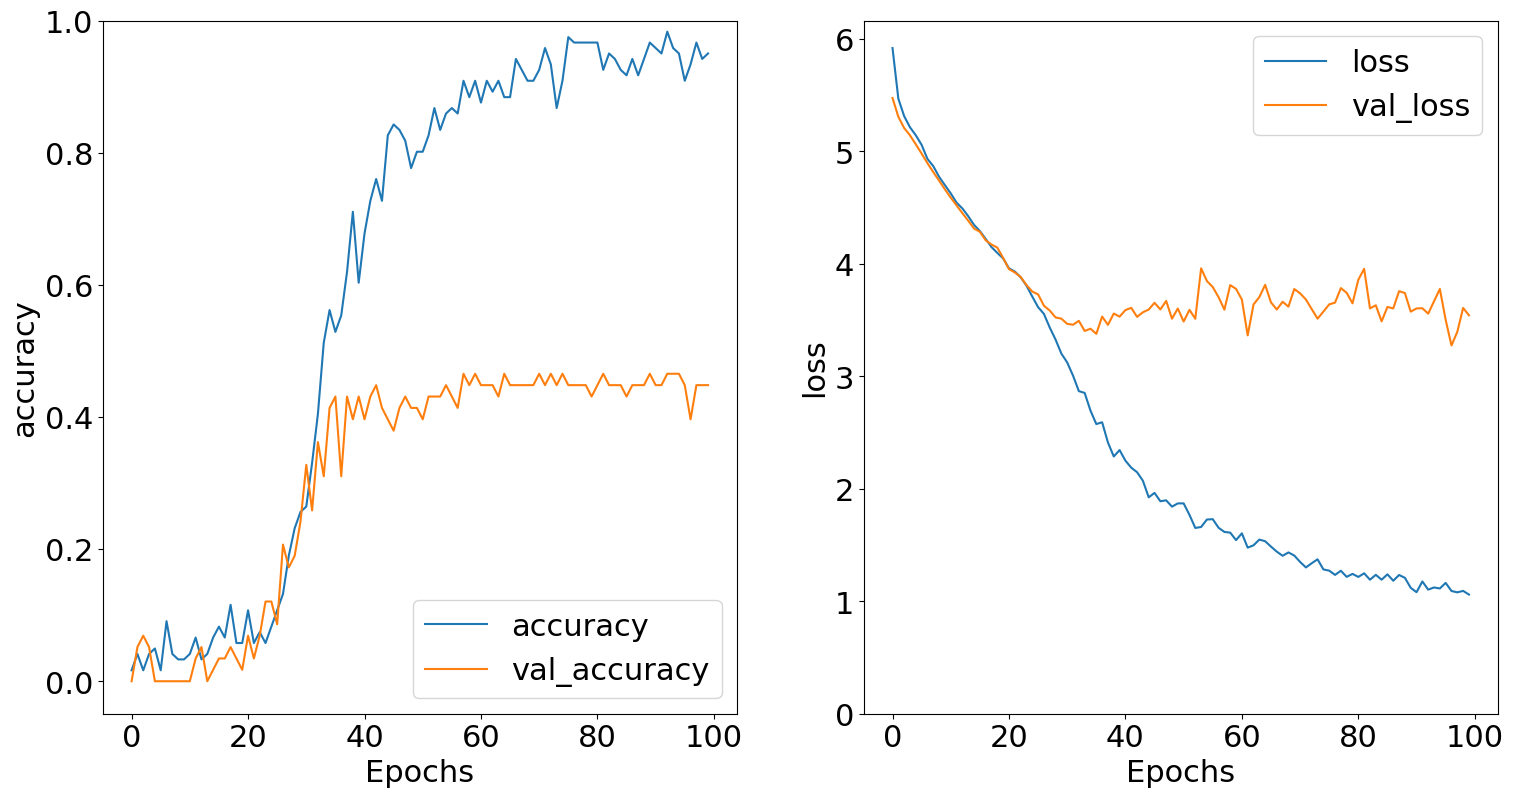

In [79]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(model, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(model, 'loss')
plt.ylim(0, None)
plt.savefig('result', dpi=200, transparent=True, format='svg')

<Figure size 432x288 with 0 Axes>

In [84]:
inp = 'college number'
result = model.predict(tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len), verbose=0)
print(NUM_CLASSES)
print(len(result[0]))
print(np.max(result))

if np.max(result) > 0.7:
  tag = le.inverse_transform([np.argmax(result)])
  print(tag)
else:
  print('not found')



30
30
0.83339906
['contactnumber']


In [ ]:
print(result[0])

[2.8241432e-04 4.2879060e-03 7.7590710e-07 7.4497000e-03 8.2408340e-05
 5.9845006e-06 3.5502598e-08 1.5401212e-05 3.2685500e-07 9.5266149e-11
 8.9804757e-08 1.1147294e-08 9.6294403e-05 2.7985513e-08 4.0258078e-06
 5.0989336e-05 1.1714350e-08 1.7660608e-05 5.0315121e-04 1.3661299e-06
 9.6527940e-05 3.6266567e-05 6.4835255e-04 1.7900743e-02 1.2570207e-02
 9.5594811e-01 1.1869113e-07 7.4090696e-07 3.0169886e-08 3.2318135e-07
 3.2154411e-08]


In [92]:
# to save the trained model
model.save("/content/drive/MyDrive/Major/chat_model_v2")

import pickle

# to save the fitted tokenizer
with open('/content/drive/MyDrive/Major/tokenizer_v2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('/content/drive/MyDrive/Major/label_encoder_v2.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)